# Deep Convolutional Generative Adversarial Network

## Was sind [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs)?
Zwei Modelle werden gleichzeitig trainiert. Ein **Generator** lernt, Bilder zu erzeugen, die echt aussehen, während ein **Diskriminator** lernt, echte Bilder von Fälschungen zu unterscheiden.

Während des Trainings wird der **Generator** immer besser darin, Bilder zu erstellen, die echt aussehen, während der **Diskriminator** immer besser darin wird, sie zu unterscheiden. Der Prozess erreicht sein Gleichgewicht, wenn der **Diskriminator** keine echten Bilder mehr von Fälschungen unterscheiden kann.

Dieses Notebook demonstriert diesen Prozess anhand des MNIST-Datensatzes. Die folgende Animation zeigt eine Reihe von Bildern, die vom **Generator** erzeugt wurden, während er 50 Epochen lang trainiert wurde. Die Bilder beginnen als zufälliges Rauschen und ähneln mit der Zeit immer mehr handgeschriebenen Ziffern.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)


### Setup

In [2]:
import os
import time

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.8.0'

### Dataset laden und vorbereiten

In [4]:
(train_images, train_labels), (other_images, other_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') # Add grey area channel as dimension 
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Modelle definieren


### Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

Der Generator verwendet 'tf.keras.layers.Conv2DTranspose'-Schichten (Upsampling), um ein Bild aus einem Seed (random noise) zu erzeugen. Begonnen wird mit einer 'Dense'-Layer, die diesen Seed als Eingabe nimmt, und dann mehrmals ein Upsampling vornimmt, bis die gewünschte Bildgröße von 28x28x1 erreicht wird.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Erstellung eines Bildes mit dem noch untrainierten Generator

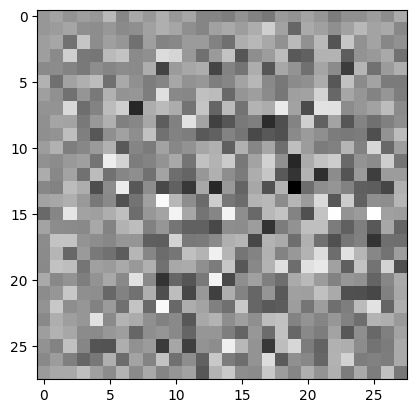

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator
Der Discriminator ist ein CNN basierter Image Classifier

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Der (noch nicht trainierte) Diskriminator wird verwendet, um die erzeugten Bilder als echt oder gefälscht zu klassifizieren. Das Modell wird so trainiert, dass es positive Werte für echte Bilder und negative Werte für gefälschte Bilder ausgibt.

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00133989]], shape=(1, 1), dtype=float32)


## Loss und Optimizer definieren

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Diese Funktion quantifiziert, wie gut der Discriminator in der Lage ist, echte Bilder von Fälschungen zu unterscheiden. Sie vergleicht die Vorhersagen des Discriminators für echte Bilder mit einer Reihe von 1en und die Vorhersagen des Diskriminators für gefälschte (generierte) Bilder mit einer Reihe von 0en.

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

Der Loss des Generators gibt an, wie gut es ihm gelungen ist, den Discriminator zu täuschen. Wenn der Generator gut funktioniert, wird der Discriminator die gefälschten Bilder als echt (oder 1) klassifizieren.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Der Discriminator und der Generator Optimizer unterscheiden sich, da 2 Modelle seperat trainiert werden.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [16]:
checkpoint_dir = './gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training loop


In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Der Trainingsloop beginnt damit, dass der Generator einen random Wert als Eingabe erhält. Dieser Seed wird verwendet, um ein Bild zu erzeugen. Der Discriminator wird dann verwendet, um echte Bilder (aus der Trainingsmenge) und gefälschte Bilder (vom Generator erzeugt) zu klassifizieren. Der Verlust wird für jedes dieser Modelle berechnet, und die Gradienten werden zur Aktualisierung des Generators und des Diskriminators verwendet.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

**Generate and save images**


In [20]:
def generate_images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

## Das Modell trainieren
Mit der Funktion `train()` werden Generator und Discriminator gleichzeitig trainiert. Beachten Sie, dass das Trainieren von GANs knifflig sein kann. Es ist wichtig, dass der Generator und der Diskriminator sich nicht gegenseitig überfordern (z.B. dass sie mit einer ähnlichen Rate trainieren).

Zu Beginn des Trainings sehen die erzeugten Bilder wie zufälliges Rauschen aus. Mit fortschreitendem Training sehen die erzeugten Ziffern immer realer aus. Nach etwa 50 Epochen ähneln sie den MNIST-Ziffern.

In [32]:
## Train Model.
# train(train_dataset, EPOCHS)

## Restore the latest checkpoint.
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

generator = tf.keras.models.load_model("mnist_generator_model.h5")

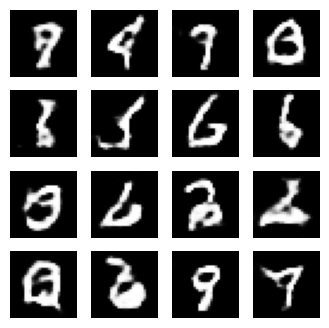

In [33]:
alt_seed = tf.random.normal([num_examples_to_generate, noise_dim])

generate_images(generator, alt_seed)

##### Copyright 2019 The TensorFlow Authors.

In [24]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.